In [30]:
#Detection breed of dog (input : image) RNC

In [54]:
# Import libraries
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import timeit
import cv2 as cv
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix 

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.vis_utils import plot_model
from keras import backend as K
import keras_tuner as kt
from keras.models import load_model

from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense

import gradio as gr

In [55]:
warnings.filterwarnings('ignore')

In [56]:
device_name = tf.test.gpu_device_name()
print(tf.__version__)
if "GPU" not in device_name:
    print("GPU device not found")
    print('Found GPU at: {}'.format(device_name))

2.3.0
GPU device not found
Found GPU at: 


In [57]:
tf.test.is_gpu_available()

False

#Preprocessing des images
#Preprocessing Images:
#1.utilisation d'un model depondra de la taille de l'image a utiliser(redimensionnemnt d'image a faire)
#best performance(best accuracy)
#model de taille contenue pour des raison materiel et logistique:
#profondeur moyenne pour ne pas surchager les calculs du temps:
#caracteristique de notre model Xception 
#Taille de 88 MB, Top-5 Accuracy à 0.945 et Depth à 126. Les images en entrée de ce modèle seront de 299px x 299px.


# 1.1. Visualisation de la liste des races 

In [58]:
#define path to data
annotation_dir = "C:/Users/elgha/Desktop/DATA/Annotation"
images_dir = 'C:/Users/elgha/Desktop/DATA/Images'

In [59]:
#Count the numer of classes (dogs breeds)
breed_list = os.listdir(image_dir)
print("Number of breeds in dataset:", (len(breed_list)))

Number of breeds in dataset: 120


120 race de dog tha we have

In [71]:
#Count number of image in each breed
#each folder we have len of images dog breed

print([len(os.listdir(images_dir + "/" + name))
          for name in breed_list])
df_breeds = pd.DataFrame(
    index=[breed.split('-',1)[1]
           for breed in breed_list],
    data=[len(os.listdir(images_dir + "/" + name))
          for name in breed_list],
    columns=["num_pictures"])

[152, 185, 252, 149, 214, 188, 196, 172, 172, 239, 175, 195, 187, 171, 159, 153, 157, 148, 151, 218, 182, 187, 188, 196, 151, 200, 232, 160, 155, 164, 182, 172, 179, 169, 172, 185, 164, 157, 197, 202, 202, 197, 196, 180, 182, 154, 157, 155, 158, 206, 183, 156, 169, 186, 152, 151, 150, 171, 167, 152, 154, 161, 155, 153, 152, 150, 159, 150, 159, 151, 150, 150, 154, 150, 150, 152, 153, 154, 169, 157, 153, 150, 150, 152, 152, 150, 184, 168, 218, 151, 202, 151, 156, 152, 159, 156, 170, 150, 178, 192, 150, 209, 200, 210, 195, 213, 218, 219, 196, 158, 153, 181, 155, 151, 155, 159, 155, 156, 150, 169]


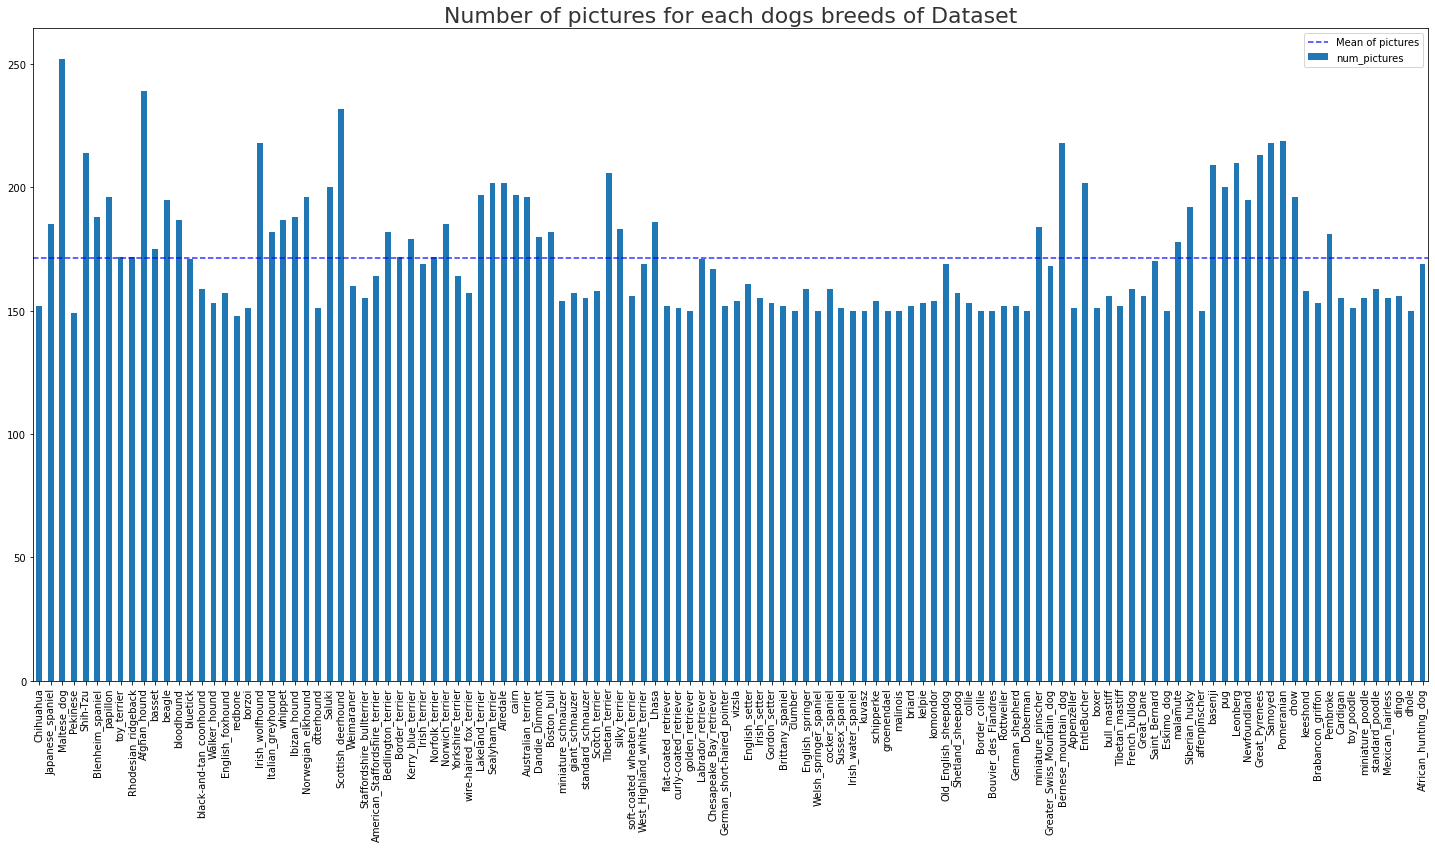

In [83]:
#plot les resulta:
fig, ax = plt.subplots(1, 1, figsize=(25,12))
df_breeds.plot(kind="bar",
               legend=False,
               ax=ax)
ax.axhline(df_breeds["num_pictures"].mean(),
           color='b', alpha=.8,
           linestyle='--',
           label="Mean of pictures")
plt.title("Number of pictures for each "\
          "dogs breeds of Dataset",
          color="#343434", fontsize=22)
plt.legend()
plt.show()

In [84]:
print(df_breeds.shape)

(120, 1)


On observe la moyenne se site a 170 photos par classe

In [101]:
def show_images_classes(path,classes,num_sample):
    """This function is used to display the first 
    n images of a directory passed as an argument. 
    It is adapted to subdirectories. 
    
    The matplotlib.image library must be loaded 
    with the alias mpimg. 

    Parameters
    ----------------------------------------
    path : string
        Link of root directory
    classes : string 
        Name of the subdirectory
    num_smaple : integer
        Number of picture to show
    ----------------------------------------
    """
    fig = plt.figure(figsize=(20,20))
    fig.patch.set_facecolor('#343434')
    plt.suptitle("{}".format(classes.split("-")[1]), y=.83,
                 color="white", fontsize=22)
    images = os.listdir(path + "/" + classes)[:num_sample]
    for i in range(num_sample):
        img = mpimg.imread(path+"/"+classes+"/"+images[i])
        plt.subplot(num_sample/5+1, 5, i+1)
        plt.imshow(img)
        plt.axis('off')
    plt.show()

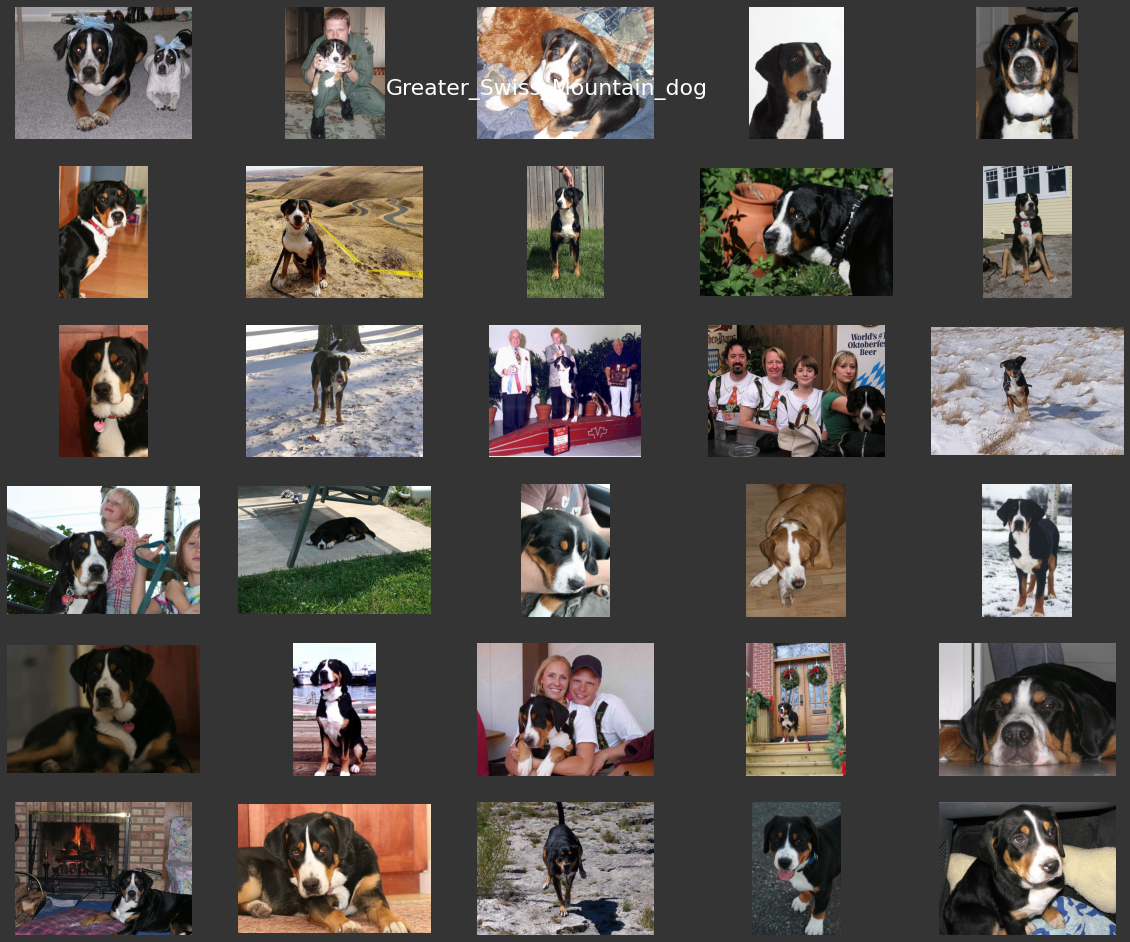

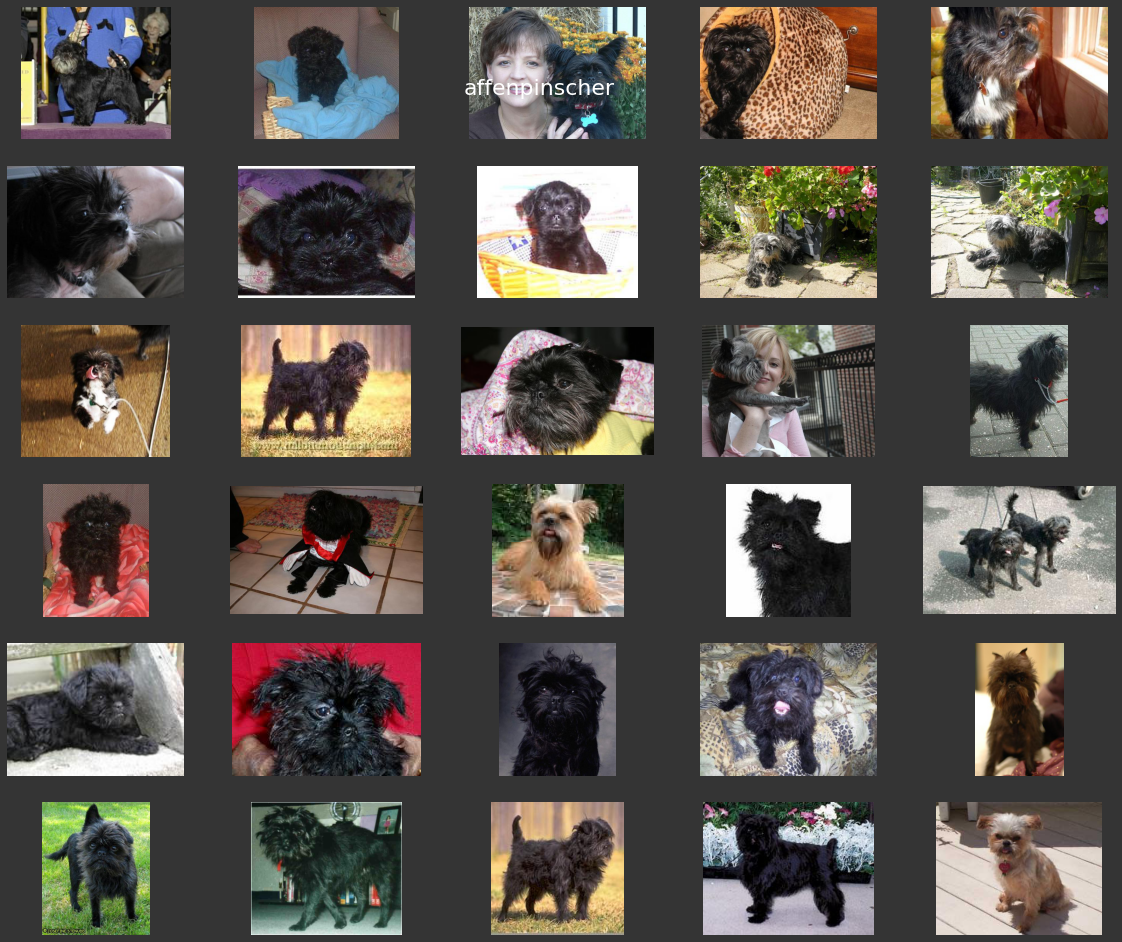

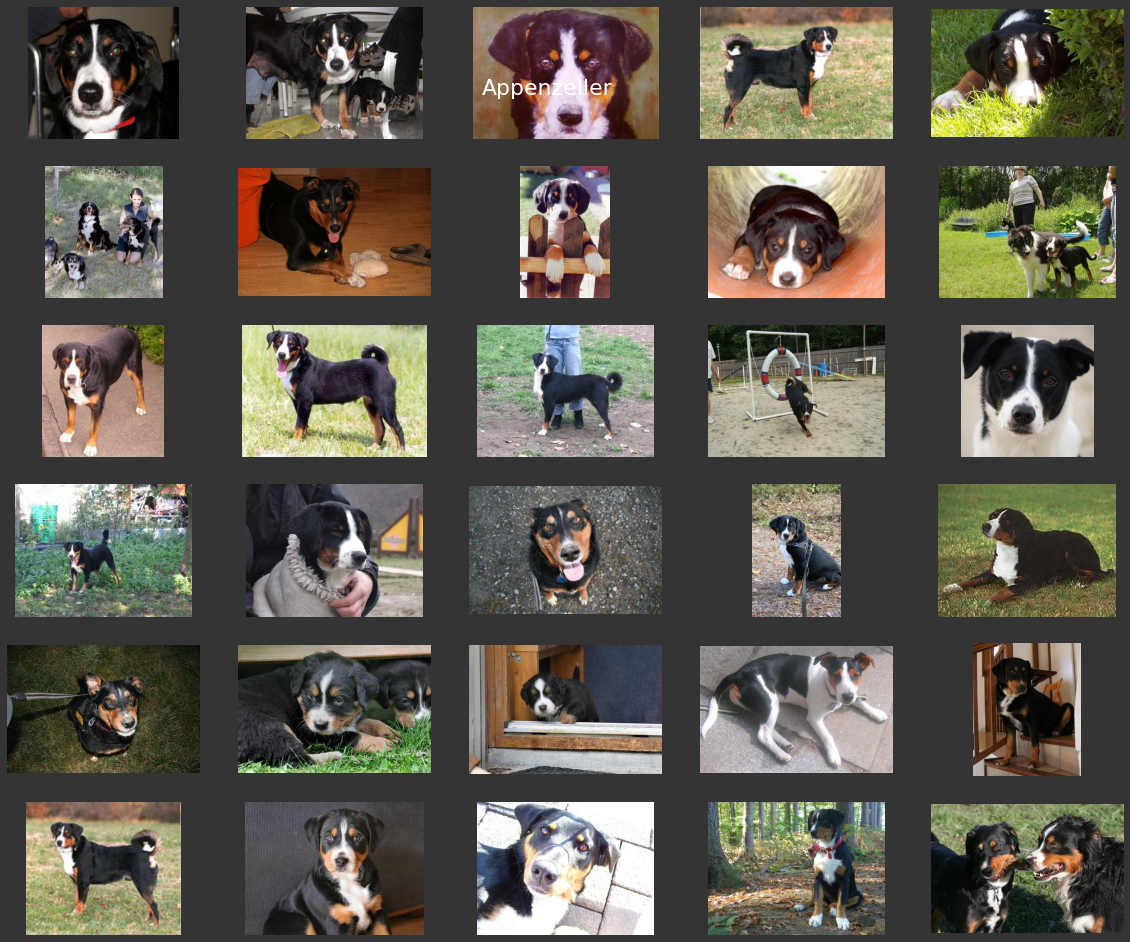

In [102]:
for i in np.random.randint(0,len(breed_list),size = 3):
    show_images_classes(images_dir, breed_list[i],30)

1.2. Modification de la taille des images :
On peut remarquer dans les images en exemple ci-dessus que les chiens presents sur les photo ne sont pas toujour au centre de la photo

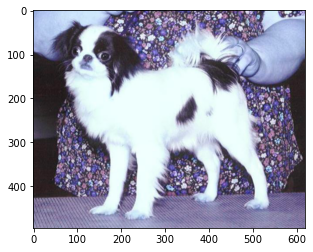

In [104]:
#Dformer les images:
img_test = (images_dir + '/' + "n02085782-Japanese_spaniel/n02085782_1626.jpg")
img_test = cv.imread(img_test)
plt.imshow(img_test)

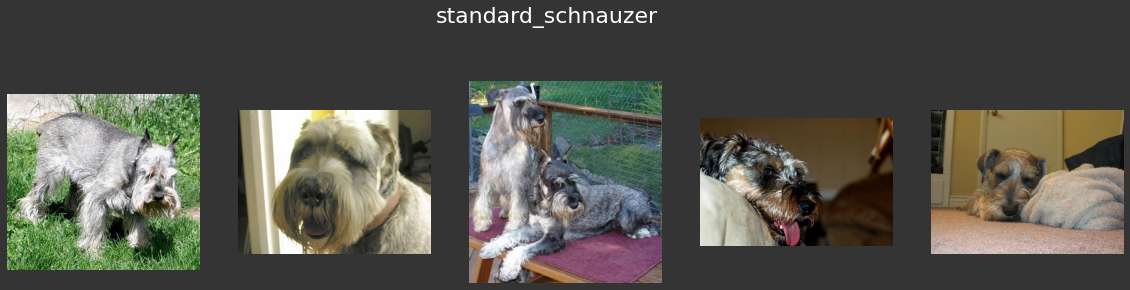

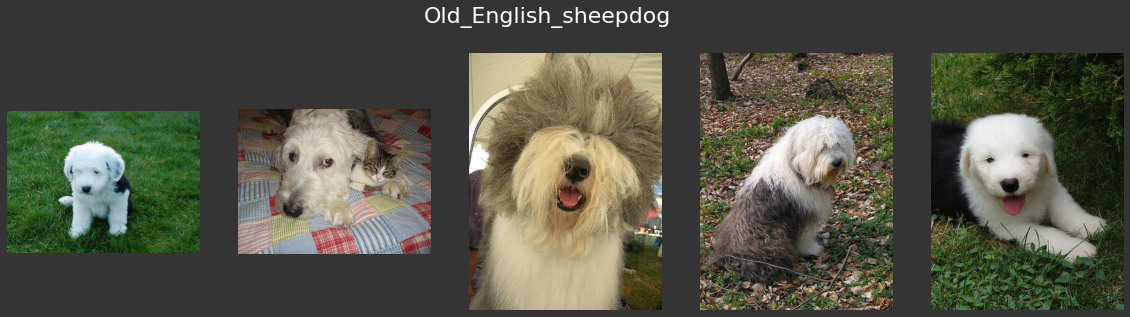

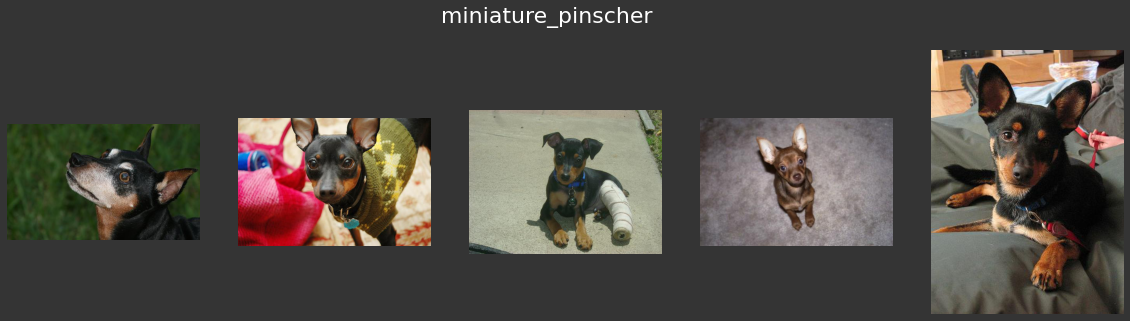

In [105]:
for i in np.random.randint(0, len(breed_list), size=3):
    show_images_classes(images_dir, breed_list[i], 5)


Nous allons devoir modifier la taille des images pour qu'elles s'adaptent aux contraintes du modèle CNN de transfert learning.



# 1.2. Modification de la taille des images
On peut remarquer dans les images en exemple ci-dessus que les chiens présents sur les photos ne sont pas toujours au centre de la photo, que les zooms sont différents. Redimensionner les images ne va pas changer ces attributs, l'image va même être déformée pour coller au nouvelles dimensions.


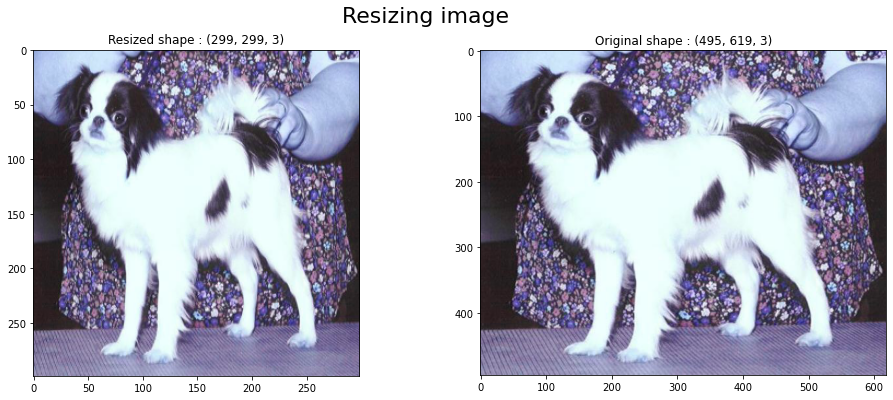

In [107]:
#setting dim of the resize
height = 299
width = 299
dim = (width,height)
#resize image with open cv
res_img = cv.resize(img_test, dim , interpolation = cv.INTER_LINEAR)

# show both img
fig = plt.figure(figsize=(16,6))
plt.subplot(1, 2, 2)
plt.imshow(img_test)
plt.title("Original shape : {}".format(img_test.shape))
plt.subplot(1, 2, 1)
plt.imshow(res_img)
plt.title("Resized shape : {}".format(res_img.shape))
plt.suptitle("Resizing image",
             color="black", 
             fontsize=22, y=.98)
plt.show()


# 1.3. Modification de l'histogramme des images
L'histogramme d'une image numérique est une courbe statistique représentant la répartition de ses pixels selon leur intensité. Commençons par regarder une image en particulier.



In [116]:
#Transform image with differents color sets
img_RGB = cv.cvtColor(img_test, cv.COLOR_BGR2RGB)
img_grayscale = cv.cvtColor(img_test, cv.COLOR_RGB2GRAY)
img_YUV = cv.cvtColor(img_test, cv.COLOR_BGR2YUV)

In [118]:
#Create Histogram
def plot_histogram(init_img, convert_img):
    """Function allowing to display the initial
    and converted images according to a certain
    colorimetric format as well as the histogram
    of the latter. 

    Parameters
    -------------------------------------------
    init_img : list
        init_img[0] = Title of the init image
        init_img[1] = Init openCV image
    convert_img : list
        convert_img[0] = Title of the converted
        convert_img[1] = converted openCV image
    -------------------------------------------
    """
    hist, bins = np.histogram(convert_img[1].flatten(), 256, [0,256])
    #Cumulative Distribution Function
    cdf = hist.cumsum()
    cdf_normalized = cdf * float(hist.max()) / cdf.max()
    # Plot histogram
    fig = plt.figure(figsize=(25,6))
    plt.subplot(1, 3, 1)
    plt.imshow(init_img[1])
    plt.title("{} Image".format(init_img[0]), 
              color="#343434")
    plt.subplot(1, 3, 2)
    plt.imshow(convert_img[1])
    plt.title("{} Image".format(convert_img[0]), 
              color="#343434")
    plt.subplot(1, 3, 3)
    plt.plot(cdf_normalized, 
             color='r', alpha=.7,
             linestyle='--')
    plt.hist(convert_img[1].flatten(),256,[0,256])
    plt.xlim([0,256])
    plt.legend(('cdf','histogram'), loc = 'upper left')
    plt.title("Histogram of convert image", color="#343434")
    plt.suptitle("Histogram and cumulative "\
                 "distribution for test image",
              color="black", fontsize=22, y=.98)
    plt.show()

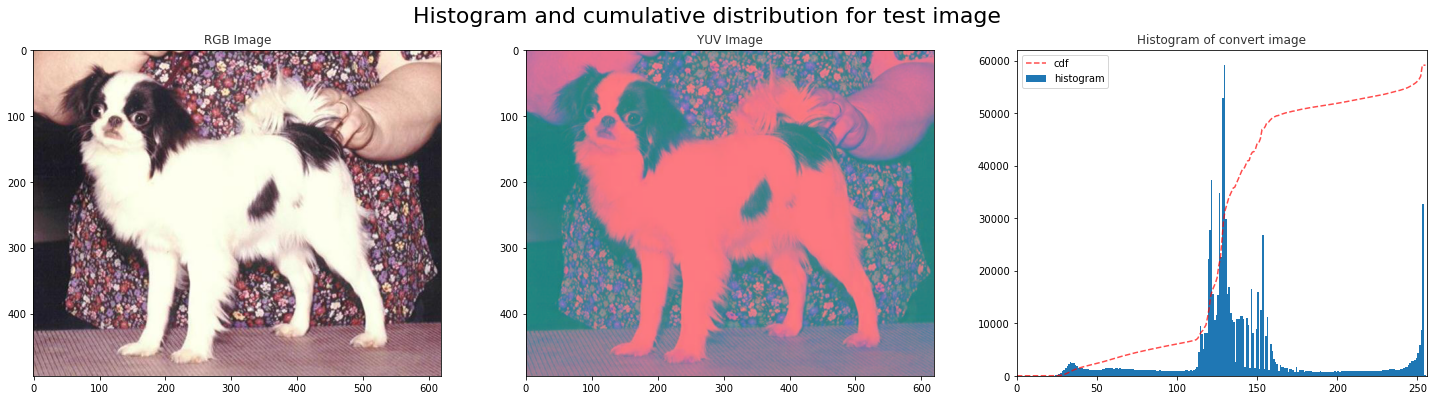

In [119]:
plot_histogram(["RGB", img_RGB], ["YUV", img_YUV])
